In [2]:
# Run this code if you get errors with missing requirements
import sys
!{sys.executable} -m pip install mysql-connector

import pandas as pd
import mysql.connector

mydb = mysql.connector.connect(
  host="iiwari-mariadb-server",
  user="root",
  passwd="d41k4Duu",
  database="iiwari_org"
)



In [3]:
mycursor = mydb.cursor(dictionary=True)
mycursor.execute("SELECT node_id, COUNT(node_id), timestamp FROM SensorData   WHERE timestamp > '2019-05-24 13:05:08.078133+00:00' AND timestamp < '2019-05-29 13:05:08.078133+00:00'  AND x > 0  AND X < 10406 AND y < 5220 AND y > 0 AND   q <100 AND z = 0 GROUP BY node_id ");
database = pd.DataFrame(mycursor.fetchall())
print(database)

#COUNT ja GROUP BY jo hakuvaiheessa



    node_id  COUNT(node_id)                            timestamp
0      3200           54824  b'2019-05-24 13:18:02.994616+00:00'
1      3224           11449  b'2019-05-24 15:40:09.994598+00:00'
2      3240            1879   b'2019-05-25 06:39:14.99468+00:00'
3     51719           32469  b'2019-05-24 16:18:18.994673+00:00'
4     51735          102006  b'2019-05-25 06:38:44.994583+00:00'
5     51751           45886  b'2019-05-24 13:05:08.987771+00:00'
6     51850          104681  b'2019-05-25 05:08:54.995013+00:00'
7     51866          113297  b'2019-05-24 13:06:52.995091+00:00'
8     51889          268178  b'2019-05-24 13:05:31.995048+00:00'
9     51968           25528  b'2019-05-24 13:17:21.994477+00:00'
10    51976           66253  b'2019-05-24 13:05:08.987162+00:00'
11    51992            1325  b'2019-05-25 06:25:51.994608+00:00'
12    52003           13915  b'2019-05-25 06:40:26.994632+00:00'
13    52008               1  b'2019-05-28 09:14:51.995571+00:00'
14    52023              

# Laitetaan timestamppi dataframeen ja poistetaan siitä turhat, lisätään kesä- ja talviajan huomionti

In [4]:
database['timestamp'] = database['timestamp'].astype('str')
database['timestamp'] = database['timestamp'].str.rstrip("'+00:00'")
database['timestamp'] = database['timestamp'].str.lstrip("b'")
database['timestamp'] = database['timestamp'].astype('datetime64[s]')

database.timestamp = database.timestamp.dt.tz_localize('UTC')
database.timestamp = database.timestamp.dt.tz_convert('Europe/Helsinki')

nodet = pd.DataFrame()

nodet['timestamp'] = database['timestamp']



print(nodet)


                   timestamp
0  2019-05-24 16:18:02+03:00
1  2019-05-24 18:40:09+03:00
2  2019-05-25 09:39:14+03:00
3  2019-05-24 19:18:18+03:00
4  2019-05-25 09:38:44+03:00
5  2019-05-24 16:05:08+03:00
6  2019-05-25 08:08:54+03:00
7  2019-05-24 16:06:52+03:00
8  2019-05-24 16:05:31+03:00
9  2019-05-24 16:17:21+03:00
10 2019-05-24 16:05:08+03:00
11 2019-05-25 09:25:51+03:00
12 2019-05-25 09:40:26+03:00
13 2019-05-28 12:14:51+03:00
14 2019-05-24 17:19:46+03:00
15 2019-05-24 16:13:02+03:00
16 2019-05-24 16:05:29+03:00
17 2019-05-24 16:15:31+03:00
18 2019-05-24 19:21:17+03:00
19 2019-05-25 01:19:10+03:00
20 2019-05-24 22:52:00+03:00
21 2019-05-25 03:13:53+03:00
22 2019-05-24 19:23:19+03:00


# Muutetaan timestamp datetime64 muotoon ja pyörristetään tunnin tarkkuudelle
### Pudotetaan aukiolon ulkopuolella olevat ajat

In [6]:
nodet['timestamp'] = nodet['timestamp'].astype('datetime64[ns]')
nodet['timestamp'] = pd.Series(nodet['timestamp']).dt.round("H")

nodet = nodet.drop(nodet[(nodet.timestamp.dt.hour > 21)].index)
nodet = nodet.drop(nodet[(nodet.timestamp.dt.hour < 8)].index)



print(nodet)

             timestamp
0  2019-05-24 13:00:00
1  2019-05-24 16:00:00
3  2019-05-24 16:00:00
5  2019-05-24 13:00:00
7  2019-05-24 13:00:00
8  2019-05-24 13:00:00
9  2019-05-24 13:00:00
10 2019-05-24 13:00:00
13 2019-05-28 09:00:00
14 2019-05-24 14:00:00
15 2019-05-24 13:00:00
16 2019-05-24 13:00:00
17 2019-05-24 13:00:00
18 2019-05-24 16:00:00
20 2019-05-24 20:00:00
22 2019-05-24 16:00:00


# laitetaan node_id count ja prosenttiosuus kärreistä

In [8]:

nodet['node_id'] = database['node_id']
nodet['count'] = database['COUNT(node_id)']
nodet['prosenttiosuus'] = 100 * (database['COUNT(node_id)'] / (database['COUNT(node_id)'].sum()))

print(nodet)

             timestamp  node_id   count  prosenttiosuus
0  2019-05-24 13:00:00     3200   54824        3.267714
1  2019-05-24 16:00:00     3224   11449        0.682403
3  2019-05-24 16:00:00    51719   32469        1.935273
5  2019-05-24 13:00:00    51751   45886        2.734976
7  2019-05-24 13:00:00    51866  113297        6.752921
8  2019-05-24 13:00:00    51889  268178       15.984403
9  2019-05-24 13:00:00    51968   25528        1.521563
10 2019-05-24 13:00:00    51976   66253        3.948924
13 2019-05-28 09:00:00    52008       1        0.000060
14 2019-05-24 14:00:00    52023      59        0.003517
15 2019-05-24 13:00:00    52099   96707        5.764096
16 2019-05-24 13:00:00    52535  130067        7.752475
17 2019-05-24 13:00:00    53011   74043        4.413237
18 2019-05-24 16:00:00    53130  201303       11.998405
20 2019-05-24 20:00:00    53924   18429        1.098437
22 2019-05-24 16:00:00    54016  282277       16.824756


# Plotataan node_id ja prosenttiosuus

Text(0.5, 0, 'Kärryn numero')

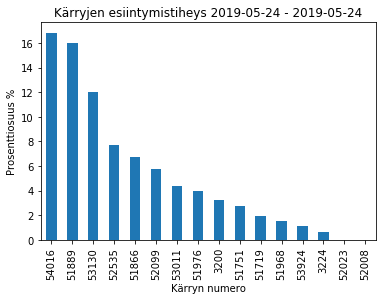

In [13]:
import pylab as plt

nodet.groupby("node_id").prosenttiosuus.mean().sort_values(ascending=False)[:23].plot.bar(title='Kärryjen esiintymistiheys ' + str(database.timestamp.dt.date.iloc[0]) + " - " + str(database.timestamp.dt.date.iloc[-1]))
plt.ylabel('Prosenttiosuus %')
plt.xlabel('Kärryn numero')